In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras
from keras import models

from keras import regularizers
import sys
import logging
sys.path.insert(0, '../')

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1


In [7]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

In [8]:
from mnist_corruption import gaussian_blurring, corrupt_data, random_perturbation, random_blackout_whiteout

In [9]:
!python --version

Python 3.7.1


In [10]:
logging.basicConfig(filename='results.log')

logger = logging.getLogger('stab.gen.expt')
handler = logging.FileHandler('results.log')
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

In [11]:
logger.warning('Hey, it is good!')

### Import the MNIST dataset/ Preprocess the data

In [49]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
x_train = x_train/255
x_test = x_test/255

In [14]:
num_classes = 10

In [15]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

In [17]:
from adv_util import create_fully_connected, create_fully_connected_k_onwards

In [18]:
def flatten_mnist(x):
    n, img_rows, img_cols = x.shape
    D = img_rows * img_cols
    x_flattened = x.reshape(n, D)
    return x_flattened, (D, )

In [19]:
x_train_flat, input_shape = flatten_mnist(x_train)
x_test_flat, _ = flatten_mnist(x_test)

In [20]:
input_shape

(784,)

## Play with norm 

# Experiment A

## Helper functions

In [97]:
def dist_calculator(reg_image, adv_image, activation_model):
    reg_image = reg_image.reshape(1, 784)
    adv_image = adv_image.reshape(1, 784)
    activation_reg = np.array(activation_model.predict(reg_image)).squeeze()
    activation_adv = np.array(activation_model.predict(adv_image)).squeeze()
    difference = activation_reg - activation_adv
    L = len(difference)
    if L == 1:
        return np.linalg.norm(activation_reg - activation_adv)
    else:
        distances = []
        for i in range(L):
            distances.append(np.linalg.norm(difference[i]))
        return distances

def dist_average(reg_set, adv_set, activation_model):
    set_card = len(reg_set)
    distances = []
    for i in range(set_card):
        dist = dist_calculator(reg_set[i], adv_set[i], activation_model)
        distances.append(dist)
    #print(np.array(distances).shape)
    return np.average(distances, axis = 0)

def dist_split(x_test_flat, x_test_adv_flat, model, activation_model):
    pred = model.predict(x_test_adv_flat)
    incorrect_indices = [i for i,v in enumerate(pred) if np.argmax(pred[i]) != np.argmax(y_test[i])]
    correct_indices = [i for i,v in enumerate(pred) if np.argmax(pred[i]) == np.argmax(y_test[i])]
    
    overall = dist_average(x_test_flat, x_test_adv_flat, activation_model)
    correct_dist = dist_average(x_test_flat[correct_indices], x_test_adv_flat[correct_indices], activation_model)
    incorrect_dist = dist_average(x_test_flat[incorrect_indices], x_test_adv_flat[incorrect_indices], activation_model)
    
    return overall, correct_dist, incorrect_dist

def adv_generate(session, model_input, epsilon_input, image_set):
    fgsm = FastGradientMethod(model_input, sess=session)
    adv_x = fgsm.generate_np(image_set, eps = epsilon_input, clip_min = -2, clip_max = 2)
    return adv_x

## Featurization distance for random perturbation

In [84]:
x_test_blur_flat = random_perturbation(x_test_flat, eps = 0.3)

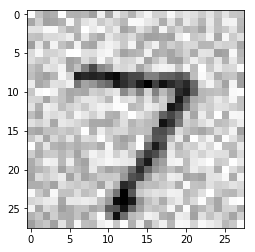

In [153]:
test_image = x_test_blur_flat[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [129]:
print(dist_split(x_test_flat, x_test_blur_flat))

(0.17712823, 0.17169413, 0.22389472)


## Featurization distance for random blackout whiteout

In [70]:
x_test_bw_flat = random_blackout_whiteout(x_test_flat)

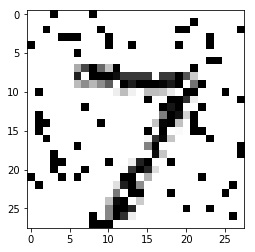

In [113]:
original_image = x_test_flat[0]
test_image = x_test_bw_flat[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [132]:
print(dist_split(x_test_flat, x_test_bw_flat))

(0.51129884, 0.4713683, 0.68616384)


In [190]:
model = big_model

In [191]:
L = len(model.layers)
print(L)
layer_output = [model.layers[i].output for i in range(L-1)]
activation_model = models.Model(inputs=model.input, outputs=layer_output)

6


In [192]:
image = x_train_flat[0].reshape(1, 784)
activation = activation_model.predict(image)

In [193]:
np.array(activation).squeeze()[0].shape

(32,)

## All layers 

In [240]:
big_model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = 4, reg = 0)
big_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
sess.run(tf.global_variables_initializer()) 
big_model.fit(x_train_flat, y_train, epochs = 15)
x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.1, x_test_flat)
print(big_model.evaluate(x_test_adv_flat, y_test))

Epoch 1/15
60000/60000 [==============================] - 8s - loss: 1.6097 - acc: 0.3255     
Epoch 2/15
60000/60000 [==============================] - 5s - loss: 0.8927 - acc: 0.6436     
Epoch 3/15
60000/60000 [==============================] - 5s - loss: 0.4524 - acc: 0.8712     
Epoch 4/15
60000/60000 [==============================] - 5s - loss: 0.3056 - acc: 0.9196     
Epoch 5/15
60000/60000 [==============================] - 5s - loss: 0.2581 - acc: 0.9315     
Epoch 6/15
60000/60000 [==============================] - 5s - loss: 0.2274 - acc: 0.9390     - ETA: 2s - loss: 0 - ETA: 1s
Epoch 7/15
60000/60000 [==============================] - 5s - loss: 0.2031 - acc: 0.9451     
Epoch 8/15
60000/60000 [==============================] - 5s - loss: 0.1861 - acc: 0.9490     
Epoch 9/15
60000/60000 [==============================] - 5s - loss: 0.1700 - acc: 0.9541     - ETA: 1s - 
Epoch 10/15
60000/60000 [==============================] - 5s - loss: 0.1573 - acc: 0.9565     
Epoch 11

[INFO 2019-06-19 14:02:23,489 cleverhans] Constructing new graph for attack FastGradientMethod



 9344/10000 [===========================>..] - ETA: 0s[7.780863311767578, 0.0753]


In [22]:
sess

NameError: name 'sess' is not defined

In [235]:
x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.1, x_test_flat)
print(big_model.evaluate(x_test_adv_flat, y_test))
L = len(big_model.layers)
layer_output = [big_model.layers[i].output for i in range(L-1)]
activation_model = models.Model(inputs=big_model.input, outputs=layer_output)

[INFO 2019-06-18 14:43:39,597 cleverhans] Constructing new graph for attack FastGradientMethod


 9728/10000 [============================>.] - ETA: 0s[6.337627924346924, 0.1153]


In [246]:
x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.05, x_test_flat)
print(big_model.evaluate(x_test_adv_flat, y_test))

[INFO 2019-07-02 16:04:56,510 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 0s     
[5.539122418212891, 0.1707]


In [236]:
#Train 1 - 10 layers
overall_adv, correct_adv, incorrect_adv = dist_split(x_test_flat, x_test_adv_flat, big_model, activation_model)

In [228]:
# This is the one with 10 hidden layers
incorrect_adv

array([2.4210875, 1.5312514, 1.7560292, 2.130251 , 2.2515316, 2.1644576,
       2.1015663, 2.1409478, 2.3008494, 2.653368 , 2.7827969],
      dtype=float32)

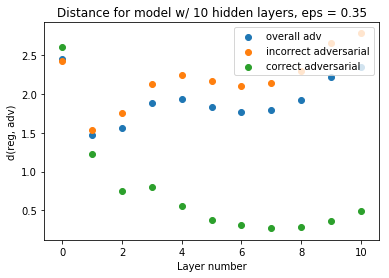

In [234]:
x = range(len(overall_adv))
plt.scatter(x, overall_adv, label = 'overall adv')
plt.scatter(x, incorrect_adv, label = 'incorrect adversarial')
plt.scatter(x, correct_adv, label = 'correct adversarial')

plt.legend(loc='upper right')
plt.xlabel('Layer number')
plt.ylabel('d(reg, adv)')
plt.title('Distance for model w/ 10 hidden layers, eps = 0.35')
plt.show()

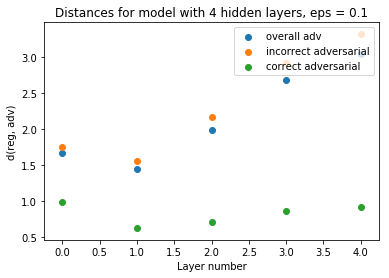

In [237]:
x = range(len(overall_adv))
plt.scatter(x, overall_adv, label = 'overall adv')
plt.scatter(x, incorrect_adv, label = 'incorrect adversarial')
plt.scatter(x, correct_adv, label = 'correct adversarial')

plt.legend(loc='upper right')
plt.xlabel('Layer number')
plt.ylabel('d(reg, adv)')
plt.title('Distances for model with 4 hidden layers, eps = 0.1')
plt.show()

In [238]:
print(correct_adv)
print(incorrect_adv)
print(overall_adv)

[0.9879302  0.6285024  0.7057162  0.8606261  0.92166793]
[1.7530615 1.5531993 2.1585233 2.919911  3.3160417]
[1.6648408 1.4465818 1.9910123 2.6824741 3.0399735]


In [110]:
#Train 10 layers on adversarial examples from 4 layers
#I ran this cell accidentally but it is interesting to see that the distances are less in this case!
#Implying that higher distance definitely has something to do with misclassification.
print(dist_split(x_test_flat, x_test_adv_flat, model, activation_model))

(array([1.8983482e-01, 4.5866568e-02, 1.0599868e-02, 2.4605270e-03,
       5.9164281e-04, 1.3207090e-04, 3.1182546e-05, 6.7690939e-06,
       1.7821782e-06], dtype=float32), array([1.9430134e-01, 4.6853833e-02, 1.0766449e-02, 2.5322465e-03,
       6.1732158e-04, 1.3911516e-04, 3.3157034e-05, 7.2132229e-06,
       1.9057740e-06], dtype=float32), array([1.8930571e-01, 4.5749702e-02, 1.0580133e-02, 2.4520296e-03,
       5.8860087e-04, 1.3123623e-04, 3.0948686e-05, 6.7164951e-06,
       1.7675396e-06], dtype=float32))


In [112]:
#Train 4 layers
print(dist_split(x_test_flat, x_test_adv_flat, model, activation_model))

(array([1.7938548, 1.4845043, 1.9475174, 2.5463245, 2.8488634],
      dtype=float32), array([1.2457126 , 0.7532576 , 0.8118865 , 0.8921975 , 0.97761166],
      dtype=float32), array([1.8587811, 1.5711156, 2.082023 , 2.742242 , 3.0705001],
      dtype=float32))


In [154]:
print(dist_split(x_test_flat, x_test_blur_flat, model, activation_model))

(array([0.55775636, 0.32986605, 0.36812672, 0.4669187 , 0.54217166],
      dtype=float32), array([0.5184117 , 0.28447244, 0.2815359 , 0.31469893, 0.33107078],
      dtype=float32), array([0.761134  , 0.5645054 , 0.81571805, 1.2537409 , 1.6333604 ],
      dtype=float32))


In [155]:
print(dist_split(x_test_flat, x_test_bw_flat, model, activation_model))

(array([1.3607831, 0.9676547, 1.2481122, 1.6766232, 1.9285892],
      dtype=float32), array([0.97070533, 0.58136886, 0.64997876, 0.7937405 , 0.8543499 ],
      dtype=float32), array([1.5935359, 1.1981431, 1.6050072, 2.2034268, 2.5695636],
      dtype=float32))


### Interpretations

- So the reducing from first to second layer seems to consistently hold independent of the number of hidden layers or the random seed used for training.
- The distance from transferred adversarial examples is low - making for an interesting control!
- In the transferrable adversarial example case - The "cascading effect" relationship of increasing distances does not hold!

### Questions

- The decreasing and increasing phenomenon is very interesting from the point of view of better decision boundary versus cascading effect. I'm not sure why it is happening.
- Observe that in the adversarial correct example case, it reduces for multiple layers before it increases. And even at the last layer, it is much less than the first layer.

# Experiment C

In [23]:
sess = tf.keras.backend.get_session()
keras.backend.set_session(sess)

In [25]:
from keras.callbacks import EarlyStopping

num_hidden_range = range(2, 11, 2)
print(num_hidden_range)
regular_metrics = []
#blur_metrics = []
#adv_metrics = []
models_saved = []
#early_stop = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.001, patience=4)


for num_hidden in num_hidden_range:
    print(num_hidden)
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = num_hidden, reg = 0)
    #print(model.summary())
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    sess.run(tf.global_variables_initializer()) 
    model.fit(x_train_flat, y_train, epochs = 15)
    models_saved.append(model)
    regular_metrics.append(model.evaluate(x_test_flat, y_test))
    #blur_metrics.append(model.evaluate(x_test_blur_flat, y_test))
    #x_test_adv_flat = adv_generate(sess, KerasModelWrapper(model), 0.05, x_test_flat)
    #adv_metrics.append(model.evaluate(x_test_adv_flat, y_test))
        

range(2, 11, 2)
2
Epoch 1/15
60000/60000 [==============================] - 3s - loss: 0.9664 - acc: 0.7436     
Epoch 2/15
60000/60000 [==============================] - 3s - loss: 0.3053 - acc: 0.9201     
Epoch 3/15
60000/60000 [==============================] - 3s - loss: 0.2176 - acc: 0.9403     
Epoch 4/15
60000/60000 [==============================] - 3s - loss: 0.1754 - acc: 0.9511     
Epoch 5/15
60000/60000 [==============================] - 3s - loss: 0.1493 - acc: 0.9582     
Epoch 6/15
60000/60000 [==============================] - 3s - loss: 0.1305 - acc: 0.9631     
Epoch 7/15
60000/60000 [==============================] - 4s - loss: 0.1169 - acc: 0.9663     
Epoch 8/15
60000/60000 [==============================] - 3s - loss: 0.1066 - acc: 0.9694     
Epoch 9/15
60000/60000 [==============================] - 3s - loss: 0.0985 - acc: 0.9717     
Epoch 10/15
60000/60000 [==============================] - 3s - loss: 0.0925 - acc: 0.9732     
Epoch 11/15
60000/60000 [======

In [26]:
from sklearn.manifold import TSNE

In [35]:
model = models_saved[0]
layer_output = model.layers[-2].output
activation_model = models.Model(inputs=model.input, outputs=layer_output)
featurized_x_train = activation_model.predict(x_train_flat)

In [36]:
featurized_x_train.shape

(60000, 32)

In [39]:
#Hoping to crete the visualizations
model = models_saved[0]
layer_output = model.layers[-2].output
activation_model = models.Model(inputs=model.input, outputs=layer_output)
featurized_x_train = activation_model.predict(x_train_flat)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(featurized_x_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.110s...
[t-SNE] Computed neighbors for 60000 samples in 233.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for 

In [55]:
tsne_results.shape

(60000, 2)

In [44]:
import pandas as pd
df = pd.DataFrame(tsne_results, columns = ['first component', 'second component'])

In [50]:
df['y'] = y_train

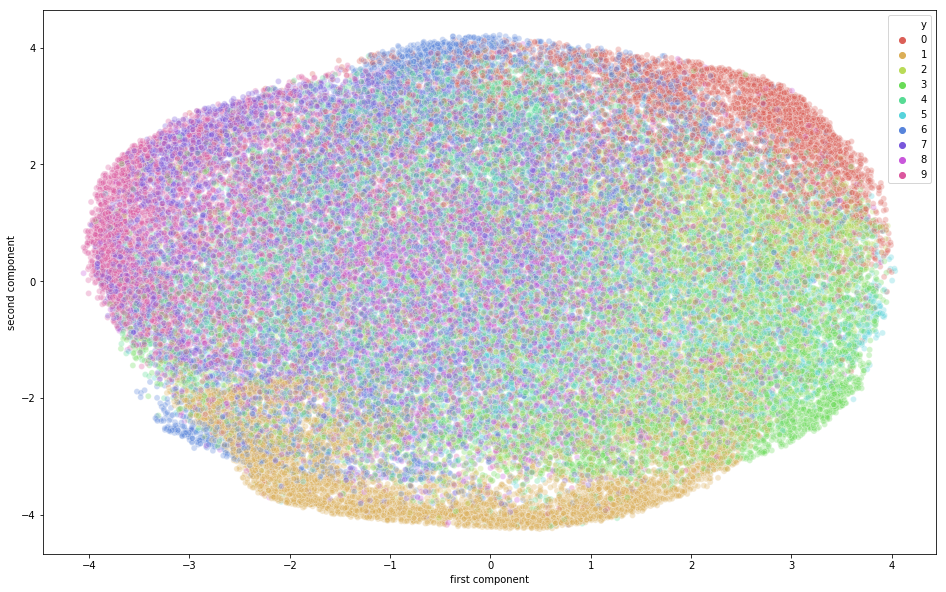

In [54]:
import seaborn as sns
rndperm = np.random.permutation(df.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="first component", y="second component",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [186]:
blur_metrics

[[1.5882078989207744, 0.7636],
 [1.5769850840568542, 0.7259],
 [1.2328743010669947, 0.7581],
 [1.2112499143600464, 0.7725],
 [0.730020228600502, 0.8253]]

In [188]:
regular_metrics

[[0.207671465171015, 0.9618],
 [0.23202319830581547, 0.9501],
 [0.22344508992284537, 0.9502],
 [0.22737637112140655, 0.9515],
 [0.3534044238209724, 0.9196]]

In [189]:
adv_metrics

[[8.416653104400634, 0.2148],
 [5.573493826293945, 0.2914],
 [4.364940982437134, 0.2706],
 [4.268519073867798, 0.3421],
 [2.8397580165863037, 0.3978]]

In [187]:
blur_metrics

[[1.5882078989207744, 0.7636],
 [1.5769850840568542, 0.7259],
 [1.2328743010669947, 0.7581],
 [1.2112499143600464, 0.7725],
 [0.730020228600502, 0.8253]]

8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)             (None, 32)                1056      
________

[INFO 2019-06-17 22:50:49,736 cleverhans] Constructing new graph for attack FastGradientMethod


 8544/10000 [========================>.....] - ETA: 0s10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)   

[INFO 2019-06-17 22:50:54,989 cleverhans] Constructing new graph for attack FastGradientMethod


 9248/10000 [==========================>...] - ETA: 0s

## Retrain new model

Hmm... Maybe this is why people have not previously studied the effect of depth on adversarial robustness.. Because the trends are hard to actually establish. 

But the cascading effect certainly seems to hold true. Understanding the cascading versus the decision boundary better would be really interesting

# Experiment B

## Load weights from the previous model 

In [96]:
adv_metrics

[[5.262954145812988, 0.2056],
 [6.705777871704101, 0.163],
 [6.306135898590088, 0.1423],
 [3.6062851570129393, 0.3136],
 [3.116396446990967, 0.3049]]

In [165]:
def adv_generate_intermed_layer_load_weights(session, big_model, k, x_train, y_train):
    print(big_model.summary())
    layer_output = big_model.layers[k-1].output
    activation_model = models.Model(inputs= big_model.input, outputs=layer_output)
    x_train_lifted = activation_model.predict(x_train)
    x_test_lifted = activation_model.predict(x_test_flat)
    print('Found new features')
    
    new_input_shape = (32,)
    model_k = create_fully_connected_k_onwards(input_shape = input_shape, new_input_shape = new_input_shape, k = k, num_classes = num_classes, num_hidden = 4, reg = 0)
    print('Created new model')
    
    print(model_k.summary())
    model_k.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    model_k.load_weights('big_model_weights.h5', by_name=True)
    print(model_k.evaluate(x_test_lifted, y_test))
    
    
    eps_range = np.arange(0.05, 0.35, 0.05)
    accuracies = []
    for eps in eps_range:
        x_test_lifted_adv = adv_generate(session, KerasModelWrapper(model_k), eps, x_test_lifted)
        accuracies.append(model_k.evaluate(x_test_lifted_adv, y_test))
    return model_k, accuracies

In [166]:
model_3_accuracies = adv_generate_intermed_layer_load_weights(sess, big_model, 3, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-17 23:17:26,877 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 8992/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:17:27,941 cleverhans] Constructing new graph for attack FastGradientMethod


 8992/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:17:28,984 cleverhans] Constructing new graph for attack FastGradientMethod


 9792/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:17:30,112 cleverhans] Constructing new graph for attack FastGradientMethod


 8416/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:17:31,242 cleverhans] Constructing new graph for attack FastGradientMethod


 8544/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:17:32,310 cleverhans] Constructing new graph for attack FastGradientMethod


 9824/10000 [============================>.] - ETA: 0s

In [170]:
model_3_accuracies_load = model_3_accuracies
model_2_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 2, x_train_flat, y_train)
model_1_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 1, x_train_flat, y_train)
model_4_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 4, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-17 23:21:31,405 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 8288/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 23:21:32,609 cleverhans] Constructing new graph for attack FastGradientMethod


 9920/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:33,800 cleverhans] Constructing new graph for attack FastGradientMethod


 9568/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:21:35,117 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:36,386 cleverhans] Constructing new graph for attack FastGradientMethod


 9184/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-17 23:21:37,857 cleverhans] Constructing new graph for attack FastGradientMethod


 8672/10000 [=========================>....] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
__________________

[INFO 2019-06-17 23:21:44,627 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 9408/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:21:46,017 cleverhans] Constructing new graph for attack FastGradientMethod


 8736/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:21:47,450 cleverhans] Constructing new graph for attack FastGradientMethod


 9856/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:48,892 cleverhans] Constructing new graph for attack FastGradientMethod


 9728/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:50,472 cleverhans] Constructing new graph for attack FastGradientMethod


 8512/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:21:51,749 cleverhans] Constructing new graph for attack FastGradientMethod


 9024/10000 [==========================>...] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
__________________

[INFO 2019-06-17 23:21:59,324 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 9984/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:22:00,736 cleverhans] Constructing new graph for attack FastGradientMethod


 8448/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:22:02,085 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:22:03,525 cleverhans] Constructing new graph for attack FastGradientMethod


 8384/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:22:04,867 cleverhans] Constructing new graph for attack FastGradientMethod


 9152/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-17 23:22:06,309 cleverhans] Constructing new graph for attack FastGradientMethod


 8224/10000 [=======================>......] - ETA: 0s

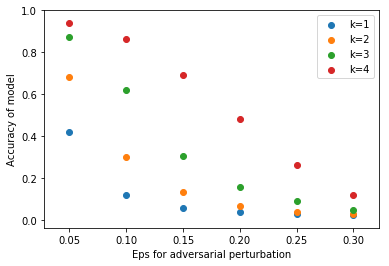

In [172]:
x = np.arange(0.05, 0.35, 0.05)
y_4 = np.array(model_4_accuracies_load[1])[:, 1]
y_3 = np.array(model_3_accuracies_load[1])[:, 1]
y_2 = np.array(model_2_accuracies_load[1])[:, 1]
y_1 = np.array(model_1_accuracies_load[1])[:, 1]
plt.scatter(x, y_1, label = 'k=1')
plt.scatter(x, y_2, label = 'k=2')
plt.scatter(x, y_3, label = 'k=3')
plt.scatter(x, y_4, label = 'k=4')

plt.legend(loc='upper right')
plt.xlabel('Eps for adversarial perturbation')
plt.ylabel('Accuracy of model')
plt.show()

## Retrain the model 

In [164]:
def adv_generate_intermed_layer(session, big_model_input, k, x_train, y_train):
    #Find the new input
    print(model.summary())
    layer_output = model.layers[k-1].output
    activation_model = models.Model(inputs=model.input, outputs=layer_output)
    x_train_lifted = activation_model.predict(x_train)
    x_test_lifted = activation_model.predict(x_test_flat)
    print('Found new features')
    
    #Create the new model
    new_input_shape = (32,)
    model_k = create_fully_connected_k_onwards(input_shape = input_shape, new_input_shape = new_input_shape, k = k, num_classes = num_classes, num_hidden = 4, reg = 0)
    print('Created new model')
    
    #Train on the new input
    print(model_k.summary())
    model_k.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    model_k.fit(x_train_lifted, y_train)
    print('trained new model')
    
    #Create the adversarial examples
    eps_range = np.arange(0.05, 0.35, 0.05)
    accuracies = []
    for eps in eps_range:
        x_test_lifted_adv = adv_generate(session, KerasModelWrapper(model_k), eps, x_test_lifted)
        accuracies.append(model_k.evaluate(x_test_lifted_adv, y_test))
    return accuracies




In [204]:
expt_output = []

In [206]:
model_3_accuracies = adv_generate_intermed_layer(sess, model, 3, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:40:10,115 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 9312/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:40:11,577 cleverhans] Constructing new graph for attack FastGradientMethod


 9248/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:40:12,472 cleverhans] Constructing new graph for attack FastGradientMethod


 9600/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:13,365 cleverhans] Constructing new graph for attack FastGradientMethod


 9440/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:14,255 cleverhans] Constructing new graph for attack FastGradientMethod


 9376/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:15,164 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

In [135]:
model_3_accuracies

(<keras.models.Sequential at 0x1c29c99630>,
 [[3.4218847301483155, 0.0892],
  [3.3436603439331054, 0.0892],
  [3.2765844337463377, 0.0892],
  [3.221594585418701, 0.0892],
  [3.1790746452331544, 0.1428],
  [3.1488127170562743, 0.1756]])

In [140]:
model_4_accuracies = adv_generate_intermed_layer(sess, model, 4, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)             (None, 32)                1056      
__________

[INFO 2019-06-17 22:58:48,158 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 8000/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 22:58:49,561 cleverhans] Constructing new graph for attack FastGradientMethod


 8320/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 22:58:50,498 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 22:58:51,394 cleverhans] Constructing new graph for attack FastGradientMethod


 9600/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 22:58:52,280 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 22:58:53,219 cleverhans] Constructing new graph for attack FastGradientMethod


 7936/10000 [======================>.......] - ETA: 0s

In [141]:
model_4_accuracies

[[0.1977435935869813, 0.9384],
 [0.39454339797496796, 0.8766],
 [0.9090400233268737, 0.6979],
 [1.875936798286438, 0.3751],
 [3.1674710525512695, 0.1307],
 [4.473508271026612, 0.0572]]

In [210]:
model_1_accuracies = adv_generate_intermed_layer(sess, model, 1, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:46:37,467 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 9024/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:46:39,129 cleverhans] Constructing new graph for attack FastGradientMethod


 8928/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:46:40,137 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:46:42,736 cleverhans] Constructing new graph for attack FastGradientMethod


 9216/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:46:43,834 cleverhans] Constructing new graph for attack FastGradientMethod


 8192/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-12 14:46:44,927 cleverhans] Constructing new graph for attack FastGradientMethod


 8480/10000 [========================>.....] - ETA: 0s

In [213]:
model_2_accuracies = adv_generate_intermed_layer(sess, model, 2, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:50:04,002 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 8704/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:05,711 cleverhans] Constructing new graph for attack FastGradientMethod


 9152/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:50:06,736 cleverhans] Constructing new graph for attack FastGradientMethod


 9888/10000 [============================>.] - ETA: 0s

[INFO 2019-06-12 14:50:07,866 cleverhans] Constructing new graph for attack FastGradientMethod


 8864/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:09,005 cleverhans] Constructing new graph for attack FastGradientMethod


 8800/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:10,052 cleverhans] Constructing new graph for attack FastGradientMethod


 9088/10000 [==========================>...] - ETA: 0s

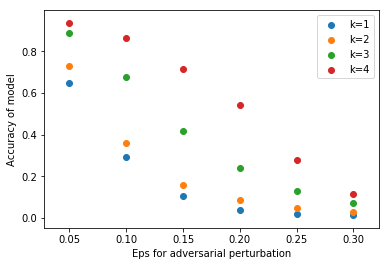

In [217]:
x = np.arange(0.05, 0.35, 0.05)
y_4 = np.array(model_4_accuracies)[:, 1]
y_3 = np.array(model_3_accuracies)[:, 1]
y_2 = np.array(model_2_accuracies)[:, 1]
y_1 = np.array(model_1_accuracies)[:, 1]
plt.scatter(x, y_1, label = 'k=1')
plt.scatter(x, y_2, label = 'k=2')
plt.scatter(x, y_3, label = 'k=3')
plt.scatter(x, y_4, label = 'k=4')

plt.legend(loc='upper right')
plt.xlabel('Eps for adversarial perturbation')
plt.ylabel('Accuracy of model')
plt.show()

### Interpretation

In the above plot, the higher that k is, the shallower the neural net is. As we can see from the plot, the shallower neural nets require higher eps to successfully attack the examples using the FGSM attack. This is in alignment with our hypothesis about the "cascading effect" making it easier to make adversarial examples for deeper networks. 

# Experiment D - Failed/ Inconclusive!

The question this section attempts to answer: Do the adversarial examples exploit the idiosyncracies in the data?

Elaboration: The noise in the data will lead the ML model to learn some relationships between the dependent and independent variables that do not truly exist. 

At a high level, for the adversary trying to find a direction of perturbation, it would be easier to find these directions in the data than find directions of actual consequence. 

So we pose the following hypothesis: The directions of adversarial perturbation should be more aligned with low singular value directions in the data rather than high singular value ones. 

In [56]:
_, sig, V = np.linalg.svd(x_test_flat)

In [57]:
x_test_flat.shape

(10000, 784)

In [58]:
V.shape

(784, 784)

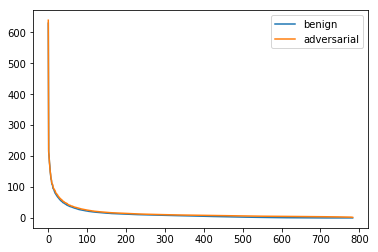

In [59]:
plt.plot(range(len(sig)), sig, label = 'benign')
plt.plot(range(len(sig)), sig_adv, label = 'adversarial')
plt.legend(loc='upper right')

In [77]:
adversarial_directions = x_test_adv_flat - x_test_flat

In [78]:
adversarial_directions = adversarial_directions.T

In [79]:
first_example = adversarial_directions[:,0]

In [80]:
projections = np.abs(V.T @ adversarial_directions)

In [81]:
average = np.average(projections, axis = 1)

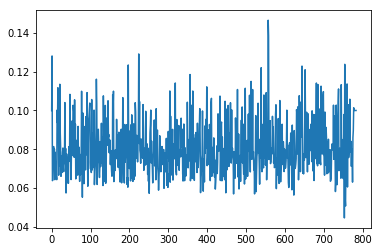

In [82]:
plt.plot(average)